## Tarefas de Manipulação

In [28]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import numpy as np

In [30]:
import os
import pathlib
import glob
import itertools
import shutil

In [31]:
import cv2
from PIL import Image, ImageShow

In [32]:
from skimage import exposure
from sklearn.preprocessing import normalize
from skimage.transform import rescale
from skimage.filters import try_all_threshold

In [33]:
from matplotlib import pyplot as plt

In [34]:
dataDir = 'data'

### Tarefa 1 - Visualização

In [35]:
def show_img(metodo:str, imgpath:str):
    """
    Recebe o path de uma imagem e plota essa imagem
    utilizando a bilbioteca escolhida no parametro path
    
    @input:
        - metodo(str): biblioteca a ser usada, valores aceitos 'cv2'(opencv), 'mpl'(matplotlib) e 'plw'(pillow)
        - imgpath(str): path da imagem
    
    @output
        - (matplotlib.image.AxesImage): imagem plotada
    """
    if metodo == 'mpl':
        img = plt.imread(imgpath)
        plt.imshow(img)
    
    elif metodo == 'plw':
        img = Image.open(imgpath)
        ImageShow.show(img)
        
    elif metodo == 'cv2':
        img = cv2.imread(imgpath)
        cv2.imshow('image',img)
        cv2.waitKey()
        cv2.destroyAllWindows()
        
    else:
        raise ValueError("o metodo deve ser alguns do valores %r"%['cv2', 'mpl', 'plw'])

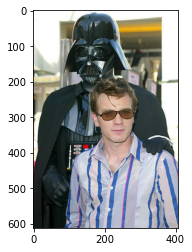

In [36]:
show_img(metodo='mpl', imgpath='data/src/DarthVader/3d25b3d4fac511fa67877039655773076c19420d.jpg')

### Tarefa 2 - Espaços de cores

$$ Y = (0.299 \times R) + (0.587 \times G )+ (0.114 \times B) $$

In [37]:
def img2bw(img):
    """
    Converter uma imagem para preto e branco usando numpy
    
    @input
        img (numpy.ndarray): Imagem a ser convertida
    @output
        (numpy.ndarray): Imagem de entrada em preto e branco
    """
    
    # Abaixo ou igual ao threshold substitui por 0
    # acima por 255
    threshold = int(np.ceil(255 / 2))   
    
    imshape = (img.shape[0], img.shape[1])
    img_bw = np.empty(imshape)
    
    xy = []

    for r in itertools.product(list(range(img.shape[0])), list(range(img.shape[1]))): 
        xy.append([r[0],r[1]])
        
    for idx in xy:
        Y = np.dot(img[idx[0], idx[1]], [.114, .587, .299])
        img_bw[idx[0], idx[1]] = [np.uint8(0) if Y <= threshold else np.uint8(255)][0]
        
    return img_bw

In [38]:
def img2bw_lib(img):
    
    # Abaixo ou igual ao threshold substitui por 0
    # acima por 255
    threshold = int(np.ceil(255 / 2))
    
    img_bw = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY )
    
    return img_bw[1]

In [48]:
def aplica_funcao(img:np.ndarray, funcao, paramns:dict=dict()):
    """
    """
    paramns['img'] = img
    img_tranf = funcao(**paramns)
    return img_tranf

In [51]:
a = show_img_comp(img, img2bw)

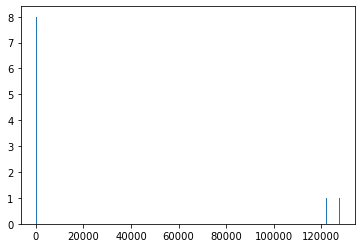

In [62]:
b = plt.hist(np.histogram(a)[0], bins=255)

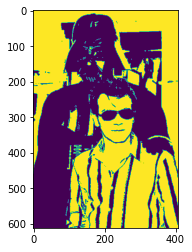

In [50]:
plt.imshow()

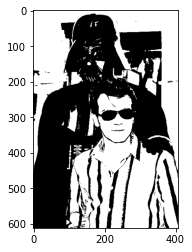

In [39]:
plt.imshow(img2bw(img), cmap='gray')

### Tarefa 3 - Augmentation

#### Flip

In [19]:
def imgFlip(img:np.ndarray, eixo:str='h'):
    """
    
    @input
        - img (np.ndarray): imagem de entrada
        - eixo (str): 'h' para inverter na horizontal e 'v' na vertical
    @output
        - np.ndarray: imagem invertida
    """
    img_out = np.empty(img.shape)
    
    if eixo == 'v':
        for i, row in enumerate(img[::-1]):
            img_out[i] = row
            
    elif eixo == 'h':
        for i, col in enumerate(img[:, ::-1]):
            img_out[i] = col
            
    else:
        raise ValueError("o eixo deve ser alguns do valores %r"%['h', 'v'])
        
    return img_out.astype(np.uint8)

In [20]:
def imgFlip_lib(img, eixo:bool=None):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    if eixo is None:
        eixo = np.random.randint(0, 2)
    else: 
        pass
    return cv2.flip(img, flipCode=eixo)

####  Rotação
$$W_{new} = W_{img}cos(\theta) + W_{img}sin(\theta)$$
$$H_{new} = H_{img}cos(\theta) + H_{img}sin(\theta)$$

[Medium](https://gautamnagrawal.medium.com/rotating-image-by-any-angle-shear-transformation-using-only-numpy-d28d16eb5076)

In [24]:
def imgRotation(img, theta:int=None):
    """
    
    @input
        - img (np.ndarray): imagem de entrada
        - theta (int): angulo de rotacao
    @output
        - np.ndarray: imagem rotacionada
    """
    
    if theta is None:
        theta = np.random.randint(1, 360)
    else: 
        pass
    
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    
    h_img, w_img, b = img.shape
    
    h_new  = round(abs( h_img * c ) + abs( h_img * s )) + 1
    w_new  = round(abs( w_img * c ) + abs( w_img * s )) + 1
    
    img_out = np.zeros((h_new,
                        w_new,
                        b))
    
    Oh = round((( h_new + 1 ) / 2 ) -1 )
    Ow = round((( w_new + 1 ) / 2 ) -1 )

    for i in range(h_img):
        for j in range(w_img):
            y = h_img - 1 - i - Oh                   
            x = w_img - 1 - j - Ow                      

            y_new = round(-x * s + y * c)
            x_new = round( x * c + y * s)

            y_new = Oh - y_new
            x_new = Ow - x_new

            if 0 <= x_new < w_new and 0 <= y_new < h_new and x_new >= 0 and y_new >= 0:
                img_out[y_new, x_new, :] = img[i, j, :] 
            
    return img_out.astype(np.uint8)

In [26]:
def imgRotation_lib(img, theta:int=None):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    if theta is None:
        theta = np.random.randint(1, 360)
    else: 
        pass
        
    h, w = img.shape[0], img.shape[1]
    
    x = ( ( w / 2 ) + 1 ) -1
    y = ( ( h / 2 ) + 1 ) -1
    
    M = cv2.getRotationMatrix2D((x, y), theta, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    
    return rotated

#### Zoom

In [27]:
def imgZoom():
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    pass

In [56]:
def imgZoom_lib(img):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    h, w, b = img.shape
    
    xi = np.random.randint(0, w)
    xf = np.random.randint(0, w)
    yi = np.random.randint(0, h)
    yf = np.random.randint(0, h)
    
    if xi + xf > w: 
        xf = w
        
    if yi + yf > h: 
        yf = h
        
    img_crop = img[yi:yi+yf, xi:xi+xf]

    return cv2.resize(img_crop, 
                      None, 
                      fx=5, fy=5, 
                      interpolation= cv2.INTER_LINEAR)

#### Constraste

In [19]:
def imgContrast():
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    pass

In [20]:
def imgContrast_lib(img):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    return cv2.convertScaleAbs(img, 
                               alpha=np.random.randint(13, 33, 1)[0]/10,
                               beta=-np.random.randint(10, 80, 1)[0])

#### Brilho

$$ s = cr^\gamma $$
<img src="https://www.researchgate.net/profile/Varun-Gopi/publication/329571120/figure/fig2/AS:962661852385285@1606527879758/Gamma-correction-curve-for-different-values-of-gdocumentclass12ptminimal.png" alt="drawing" width="400"/>

[Fonte](https://www.researchgate.net/figure/Gamma-correction-curve-for-different-values-of-gdocumentclass12ptminimal_fig2_329571120)
https://en.wikipedia.org/wiki/Gamma_correction

In [21]:
def imgBrightness(img, r, gamma):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    
    lut_matrix = 255 * r * (np.linspace(0, 1, 256) ** gamma)
    lut_matrix = np.minimum(lut_matrix, 255).astype('uint8')

    return lut_matrix[img]

In [22]:
def imgBrightness_lib(img):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    return cv2.convertScaleAbs(img, 
                               alpha=np.random.randint(13, 33, 1)[0]/10,
                               beta=np.random.randint(10, 80, 1)[0])

#### Aplicando as funções

In [63]:
def do_augmentation():
    """
    
    @input
        - img (np.ndarray): 
    """
    outdir = 'data/augmentation/'
    indir = 'data/src/'
    
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    os.makedirs(outdir)
    
    for d in os.listdir(indir):
        dirname = indir + d
        
        idx = 0
        for f in os.listdir(dirname):
            filename = os.path.join(dirname, f)
            img = plt.imread( filename )
            plt.imsave(outdir + d + '_0_' + str(idx) + '.jpg', img)
            
            for j,funcao in enumerate([imgFlip_lib, 
                                       imgRotation_lib, 
                                       imgBrightness_lib, 
                                       #imgZoom_lib,
                                       imgContrast_lib]):
                img_ret = funcao(img)
                outname = outdir + d + '_' + str(j) + '_' + str(idx) + '.jpg'
                plt.imsave(outname, img_ret)
                idx += 1

In [64]:
do_augmentation()

### Tarefa 4 - Filtros

In [ ]:
def imgBlur_Lib(img):
    """
    
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    pass